In [4]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
MODEL = "gpt-4o"
api_key = os.getenv("API_KEY")
client = OpenAI(api_key=api_key)
completion = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "あなたは役に立つアシスタントです。私の数学の宿題を手伝ってください！"}, # システムメッセージ
        {"role": "user", "content": "こんにちは！2+2を解いてくれますか？"}
    ]
)
print("assistant:" + completion.choices[0].message.content)

assistant:もちろんです！2 + 2 は 4 です。他に質問があれば、どうぞお知らせください。


# 画像処理
- GPT4oは画像を直接処理
- 画像の入力形式
    - Base64エンコード
    - URL


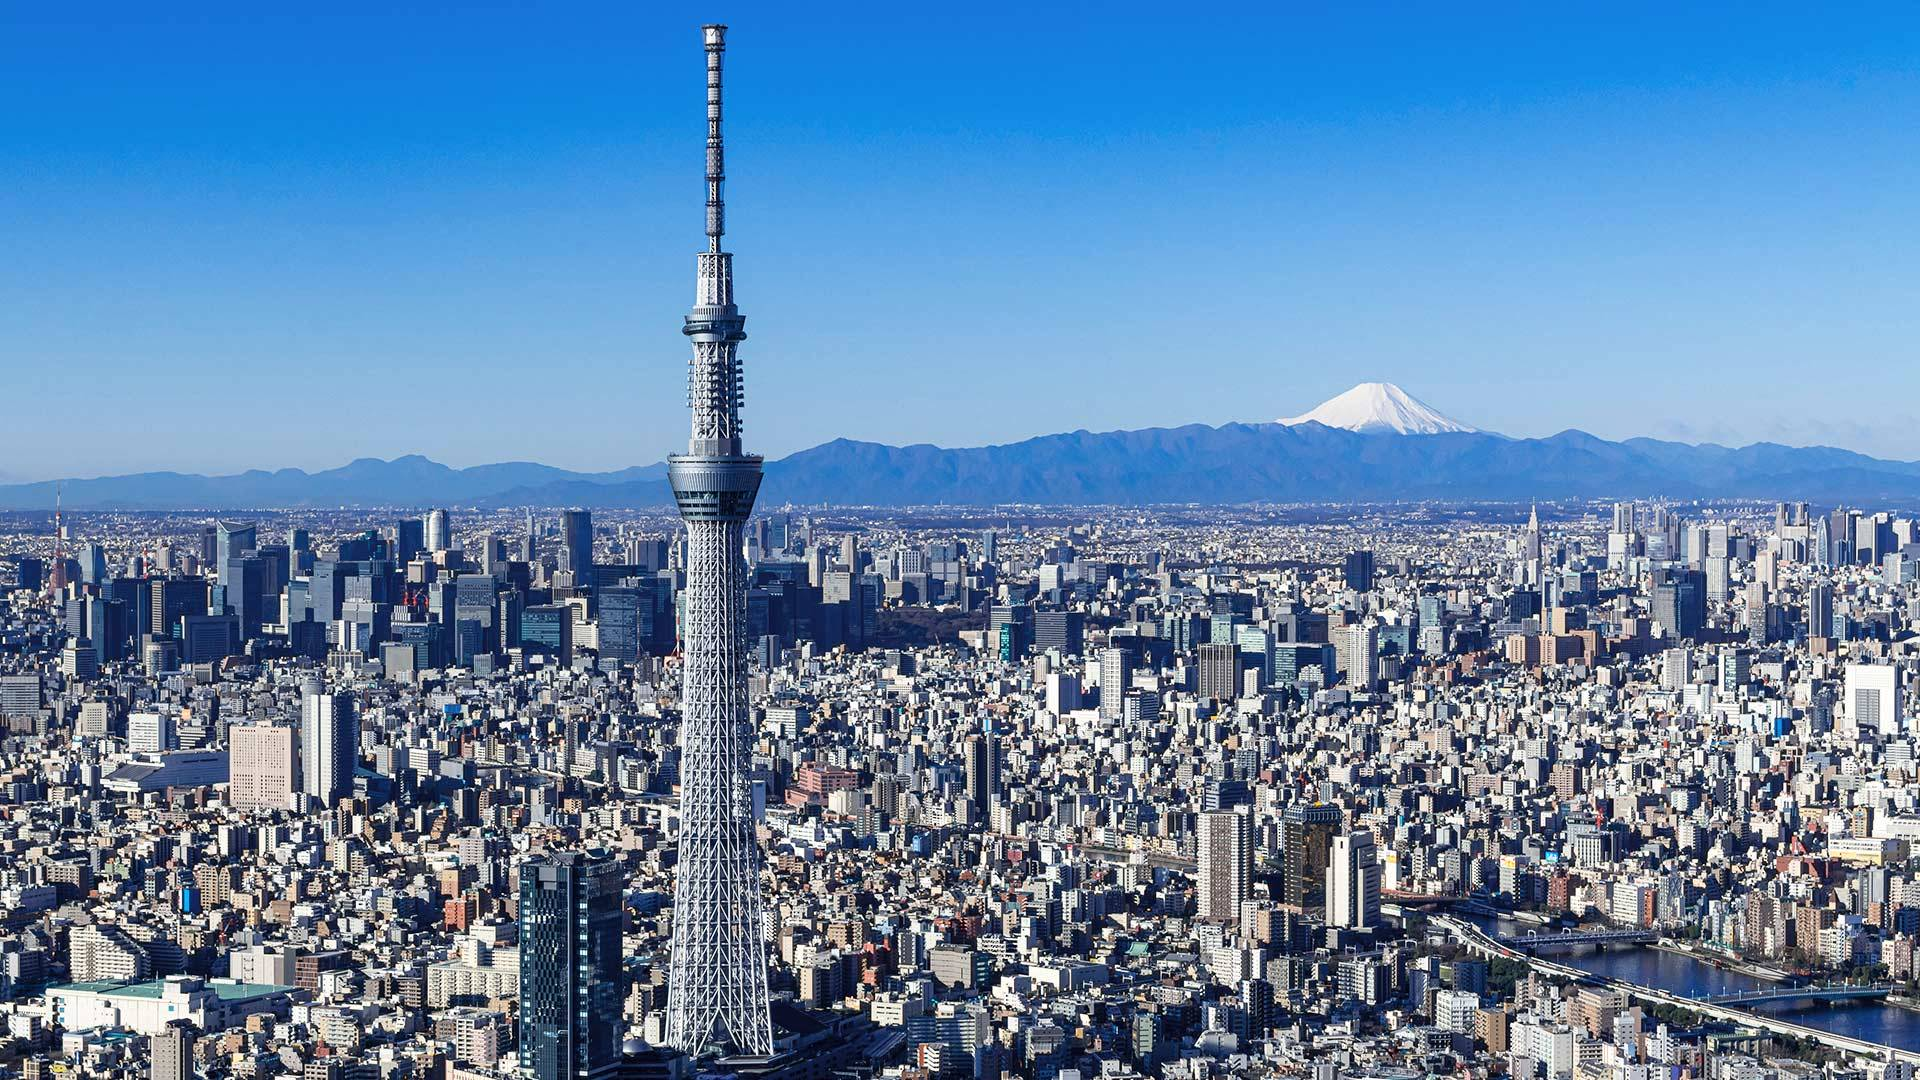

In [7]:
from IPython.display import Image, display, Audio, Markdown
import base64

IMAGE_PATH = "./スカイツリー.jpeg"

display(Image(IMAGE_PATH))

In [9]:
# Base64画像処理
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

base64_image = encode_image(IMAGE_PATH)

response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role":"system", "content":"あなたは、地理マスターです"},
        {"role":"user", "content":[
            {"type":"text", "text":"これはなんの写真？"},
            {'type':"image_url", "image_url":{
                "url":f"data:image/png;base64,{base64_image}"
            }}
        ]}
    ],
    temperature=0.0
)

print(response.choices[0].message.content)

この写真は、東京スカイツリーとその周辺の東京の都市景観を写したものです。背景には富士山も見えます。東京スカイツリーは日本の東京にある電波塔で、観光名所としても有名です。


In [10]:
# url画像版
response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role":"system", "content":"あなたは、地理マスターです"},
        {"role":"user", "content":[
            {"type":"text", "text":"これはなんの写真？"},
            {"type":"image_url", "image_url":{"url":"https://www.gotokyo.org/jp/destinations/eastern-tokyo/skytree-and-around/images/xmain_g10027.jpg.pagespeed.ic.rRFDNnqsNC.jpg"}}
        ]}
    ],
    temperature=0.0
)
print(response.choices[0].message.content)

この写真は、東京スカイツリーとその周辺の東京の都市景観を写したものです。背景には富士山が見えます。東京スカイツリーは日本の東京にある電波塔で、観光名所としても有名です。


### 動画を要約してみる

./test_movie .mp4
< cv2.VideoCapture 0x14469d430>
1996
29.970251222327537
True [[[175 203 222]
  [175 203 222]
  [175 203 222]
  ...
  [ 18  17  15]
  [ 18  17  15]
  [ 18  17  15]]

 [[175 203 222]
  [175 203 222]
  [175 203 222]
  ...
  [ 18  17  15]
  [ 18  17  15]
  [ 18  17  15]]

 [[175 203 222]
  [175 203 222]
  [175 203 222]
  ...
  [ 18  17  15]
  [ 18  17  15]
  [ 18  17  15]]

 ...

 [[138 138 144]
  [138 138 144]
  [138 138 144]
  ...
  [187 207 230]
  [182 202 225]
  [178 197 221]]

 [[138 138 144]
  [138 138 144]
  [138 138 144]
  ...
  [187 207 230]
  [182 202 225]
  [178 197 221]]

 [[138 138 144]
  [138 138 144]
  [138 138 144]
  ...
  [187 207 230]
  [182 202 225]
  [178 197 221]]]
True [[[ 15  15  15]
  [ 15  15  15]
  [ 15  15  15]
  ...
  [198 237 255]
  [196 237 255]
  [196 237 255]]

 [[ 15  15  15]
  [ 15  15  15]
  [ 15  15  15]
  ...
  [198 237 255]
  [196 237 255]
  [196 237 255]]

 [[ 15  15  15]
  [ 15  15  15]
  [ 15  15  15]
  ...
  [198 237 255]
  [198 2

MoviePy - Done.
抽出されたフレーム数: 17
音声が抽出されたパス: ./test_movie.mp3


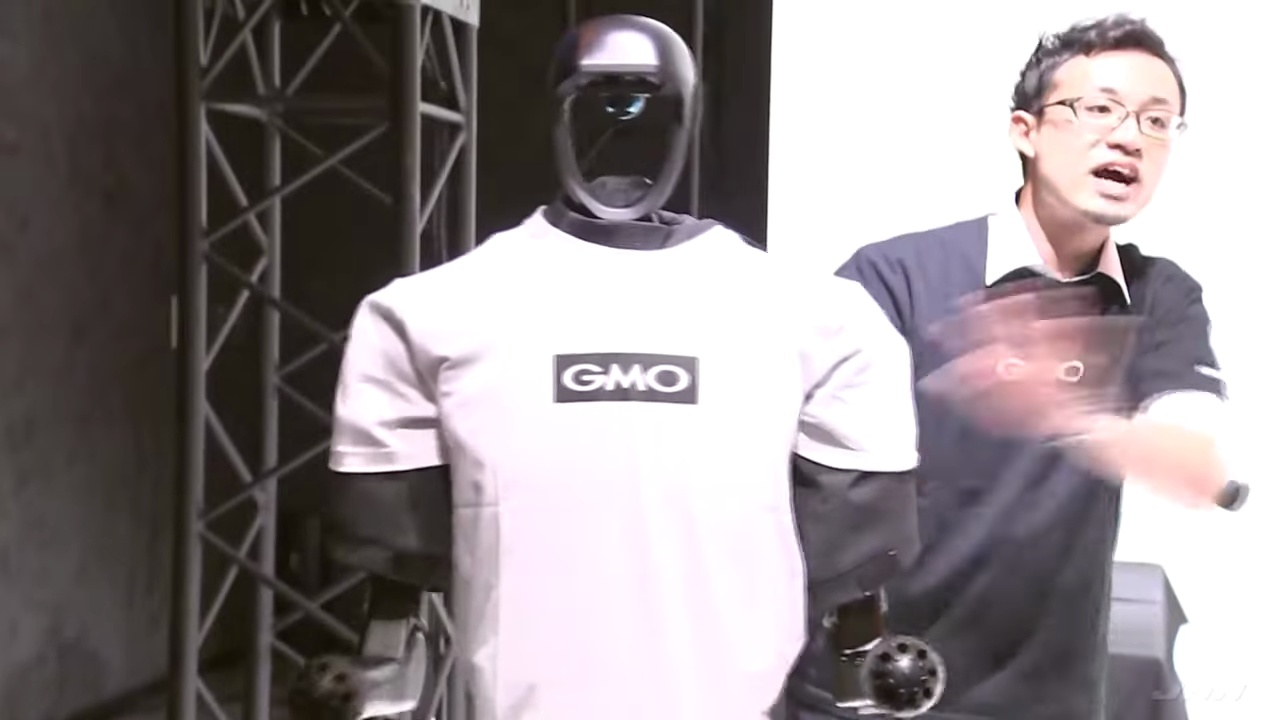

In [21]:
# まずは動画と音声を分割して抽出
import cv2
from moviepy.editor import VideoFileClip
import time
import base64

VIDEO_PAHT = "./test_movie.mp4"

def process_video(video_path, seconds_per_frame=2):
    base64Frames = []
    # ファイル名と拡張子に分割
    base_video_path, _ = os.path.splitext(video_path)
    print(base_video_path, _)
    # ビデオキャプチャオブジェクトを作成
    video = cv2.VideoCapture(video_path)
    print(video)
    # 総フレーム数を取得
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print(total_frames)
    # フレームレートを取得
    fps = video.get(cv2.CAP_PROP_FPS)
    print(fps)
    
    # 指定した間隔でフレームをスキップ
    frames_to_skip = int(fps * seconds_per_frame)
    # 現在のフレーム数を初期化
    curr_frame = 0

    # 指定されたサンプリングレートで動画からフレームを抽出
    while curr_frame < total_frames -1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        print(success, frame)

        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    # 動画から音声を抽出
    audio_path = f"{base_video_path}.mp3"
    clip = VideoFileClip(video_path)
    clip.audio.write_audiofile(audio_path, bitrate="32k")
    clip.audio.close()
    clip.close()

    print(f"抽出されたフレーム数: {len(base64Frames)}")
    print(f"音声が抽出されたパス: {audio_path}")
    return base64Frames, audio_path


base64Frames, audio_path = process_video(VIDEO_PAHT, seconds_per_frame=4)
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")),width=600))
    time.sleep(0.025)
Audio(audio_path)

In [22]:
response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content": "動画の要約を生成しています。動画の要約を提供してください。Markdownで応答してください。"},
    {"role": "user", "content": [
        "これらは動画のフレームです。",
        *map(lambda x: {"type": "image_url", "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames)
        ],
    }
    ],
    temperature=0,
)
print(response.choices[0].message.content)

### 動画の要約

この動画は、ソフトバンクグループの代表取締役社長がAI（人工知能）の未来について語るプレゼンテーションの様子を収めたものです。以下は主要なポイントです：

1. **プレゼンテーションの開始**:
   - 午前10時過ぎにプレゼンテーションが開始され、ソフトバンクの代表取締役社長が登壇します。

2. **AIの重要性と目標**:
   - 「人類の1万倍の知能のAI実現」というテーマで、AIの開発に対する強い思いを語ります。
   - ソフトバンクの使命として「人類の進化」を掲げ、AI技術の進展がその一環であると説明します。

3. **AIの未来予測**:
   - AIがどの天才よりも1万倍賢くなると予測し、10年以内にその実現が可能であると述べます。

4. **ソフトバンクの使命**:
   - ソフトバンクの使命は「人類の進化」であり、AI技術の発展がその中心にあると強調します。
   - 自身がこの使命のために生まれたと述べ、強い決意を示します。

5. **AIとロボットの融合**:
   - AI（頭脳）とロボット（身体）の融合により、人々の生活を支える存在になると説明します。
   - AIロボットが生産や道路の掃除、買い物などあらゆることをこなす未来を描きます。

6. **具体的な事例**:
   - ボストンダイナミクスのロボット技術を紹介し、AIロボットの実用化に向けた取り組みを示します。

このプレゼンテーションは、ソフトバンクがAI技術の発展に向けてどのようなビジョンを持ち、どのように取り組んでいるかを示すものであり、AIの未来に対する期待と決意が強く表現されています。


In [23]:
# 音声の書き起こし
transcription = client.audio.transcriptions.create(
    model="whisper-1",
    file=open(audio_path, "rb")
)

response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role":"system", "content":"トランスクリプトの要約を生成しています。提供されたトランスクリプトの要約を作成してください"},
        {"role":"user", "content":[
            {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
        ],
        }
    ],
    temperature=0,
)
print(response.choices[0].message.content)

孫正義社長が8ヶ月ぶりに公の場に姿を見せ、AI開発への強い思いを強調しました。彼は、AIが人間よりも1万倍賢くなるとし、それが10年以内に実現すると予測しています。孫社長は、これをソフトバンクグループの使命と位置づけ、AIロボットが生産や掃除、買い物など多岐にわたる分野で活用される未来を描きました。


In [24]:
# 音声＋視覚要約
response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role":"system", "content":"動画とトランスクリプトの要約を生成しています。提供された動画とそのトランスクリプトの要約を作成してください。Markdownで応答してください。"},
        {"role":"user", "content":[
            "これらは動画のフレームです。",
            *map(lambda x: {"type": "image_url", "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames),
            {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
        ],
        }
    ],
    temperature=0,
)
print(response.choices[0].message.content)

### 動画の要約

ソフトバンクグループの孫正義社長が、8ヶ月ぶりに公の場に姿を見せました。彼が強調したのは、AI開発への強い思いであり、人間より遥かに賢くなるAIの実現です。孫社長は、どの天才よりも1万倍賢いAIが10年以内に実現すると確信しており、それを実現するのはソフトバンクグループと自身の使命だと述べました。

さらに、孫社長はAIロボットが生産や道路の掃除、買い物などあらゆることをこなすようになると説明しました。AIロボットは既にさまざまな業種で活用が始まっており、今後の展開に期待が寄せられています。

### 主要ポイント
- 孫正義社長が8ヶ月ぶりに公の場に登場
- AI開発への強い思いを強調
- どの天才よりも1万倍賢いAIが10年以内に実現すると確信
- ソフトバンクグループと孫正義の使命としてAIの実現を掲げる
- AIロボットが生産や掃除、買い物など多岐にわたる分野で活用される見通し

この発表は、ソフトバンクグループの未来ビジョンとAI技術の進化に対する強い意欲を示しています。
